In [88]:
#!pip3 install gensim

In [89]:
#!pip3 install nltk

In [90]:
#!pip3 install razdel

In [91]:
#!pip3 install pymorphy2

In [92]:
#!pip3 install python-Levenshtein

In [93]:
import pandas as pd

Наши новости

In [94]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [95]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [96]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [97]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel



In [98]:
import pymorphy2  # pip install pymorphy2

In [99]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [100]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [101]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [102]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 1min 1s


In [103]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 9min 30s


А теперь в 3 строчки обучим нашу модель

In [104]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [105]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [106]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 2min 14s


In [107]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [108]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(2, 0.14865434), (4, 0.38311875), (6, 0.42596468), (12, 0.023585843)]

In [109]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: собственность сибирь частичный таблетка мешок непрерывный пермь
topic_1: тепло величина достигать звёздный разделение родить седьмой
topic_2: экономика производитель блок сша одежда сохранение вклад
topic_3: рубль сотрудник уголовный статья дело суд задержать
topic_4: это всё очень свой человек говорить хороший
topic_5: год который это научный свой время мочь
topic_6: звезда год стать параметр характерный парк летний
topic_7: операция проверка квартира авария аэропорт воздух погода
topic_8: гражданин ребёнок год человек агентство женщина банк
topic_9: это год который компания мочь млрд рост
topic_10: пенсия возраст зарплата мозг плата год заработный
topic_11: университет врач мальчик кость дональд боль ii
topic_12: иран испытание вода след озеро внедрение снежный
topic_13: военный сша остров боевой космонавт год ссср
topic_14: год который это также nn правительство глава
topic_15: россия это москва проект который власть nn
topic_16: год тыс млн место исследование человек первы

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [110]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [111]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.088880,0.0,0.595922,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.037058,0.000000
1,4896,0.0,0.0,0.000000,0.160384,0.000000,0.0,0.273570,0.0,0.000000,...,0.0,0.450587,0.0,0.094433,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,4897,0.0,0.0,0.148622,0.000000,0.383160,0.0,0.425970,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,4898,0.0,0.0,0.000000,0.000000,0.557344,0.0,0.063571,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.015374,0.059004,0.128169
4,4899,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.164453,0.0,0.075451,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.159287


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [112]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [113]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [114]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.16717225, 0.28156415, 0.        , 0.1093124 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.30386153,
       0.        , 0.08001535, 0.        , 0.04653477, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

### Используем среднее значение

In [153]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [154]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.        , 0.09493785, 0.02222249,
       0.1239375 , 0.        , 0.        , 0.00675015, 0.08782296,
       0.        , 0.00398184, 0.        , 0.02961266, 0.27930364,
       0.04685086, 0.0257723 , 0.        , 0.09371419, 0.        ,
       0.00273838, 0.12385832, 0.        , 0.        , 0.04492933])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [155]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.0,0.004898,0.060436,0.033420,0.105657,0.066362,0.003397,0.055663,...,0.074584,0.093205,0.013845,0.027648,0.0,0.0,0.036505,0.0,0.017573,0.116261
1,u108690,0.001703,0.0,0.003799,0.052515,0.097930,0.093997,0.000000,0.008023,0.026496,...,0.088260,0.022261,0.000000,0.016119,0.0,0.0,0.179405,0.0,0.014930,0.070931
2,u108339,0.000000,0.0,0.005824,0.054453,0.004764,0.041305,0.010658,0.025203,0.048992,...,0.118961,0.038496,0.000000,0.010187,0.0,0.0,0.145331,0.0,0.006865,0.124007


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [156]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [157]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.0,0.004898,0.060436,0.033420,0.105657,0.066362,0.003397,0.055663,...,0.093205,0.013845,0.027648,0.0,0.0,0.036505,0.0,0.017573,0.116261,0
1,u108690,0.001703,0.0,0.003799,0.052515,0.097930,0.093997,0.000000,0.008023,0.026496,...,0.022261,0.000000,0.016119,0.0,0.0,0.179405,0.0,0.014930,0.070931,1
2,u108339,0.000000,0.0,0.005824,0.054453,0.004764,0.041305,0.010658,0.025203,0.048992,...,0.038496,0.000000,0.010187,0.0,0.0,0.145331,0.0,0.006865,0.124007,1


In [158]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [159]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [160]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [161]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.12037886, 0.38195471, 0.4972604 , 0.20969191, 0.03821838,
       0.05654809, 0.094515  , 0.05396306, 0.13517154, 0.0727882 ])

In [162]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [163]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
A = ['mean', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]
A

['mean',
 0.2819078690704592,
 0.71875,
 0.6891385767790262,
 0.7510204081632653,
 0.9602814117099832]

In [164]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1672   83]
 [  62  183]]


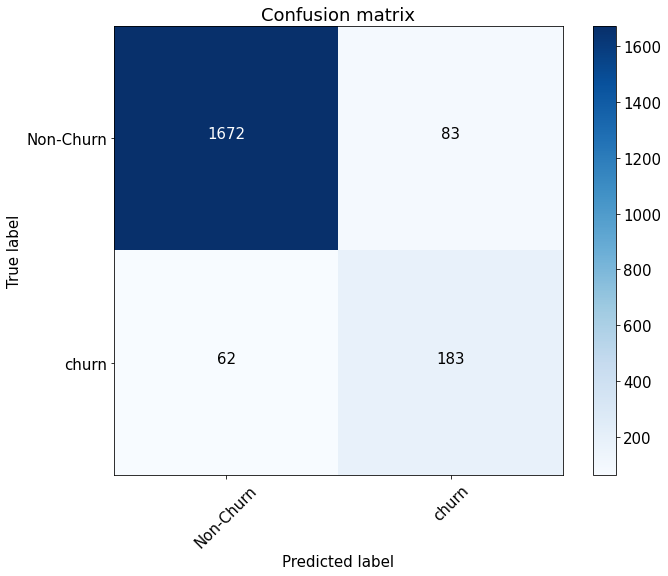

In [165]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Используем медиану

In [166]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [167]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.13181575, 0.        , 0.        , 0.        , 0.08471866,
       0.        , 0.        , 0.        , 0.        , 0.26229081,
       0.01553039, 0.        , 0.        , 0.04026586, 0.        ,
       0.        , 0.10407906, 0.        , 0.        , 0.01048828])

In [168]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.0,0.0,0.000000,0.000000,0.122288,0.0,0.000000,0.015839,...,0.000000,0.076110,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.056846
1,u108690,0.0,0.0,0.0,0.007668,0.058614,0.084104,0.0,0.000000,0.008168,...,0.080550,0.008614,0.0,0.010181,0.0,0.0,0.128011,0.0,0.0,0.041950
2,u108339,0.0,0.0,0.0,0.045599,0.000000,0.040575,0.0,0.021927,0.049267,...,0.136616,0.000000,0.0,0.000000,0.0,0.0,0.070560,0.0,0.0,0.136861


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [169]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [170]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.0,0.0,0.000000,0.000000,0.122288,0.0,0.000000,0.015839,...,0.076110,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.056846,0
1,u108690,0.0,0.0,0.0,0.007668,0.058614,0.084104,0.0,0.000000,0.008168,...,0.008614,0.0,0.010181,0.0,0.0,0.128011,0.0,0.0,0.041950,1
2,u108339,0.0,0.0,0.0,0.045599,0.000000,0.040575,0.0,0.021927,0.049267,...,0.000000,0.0,0.000000,0.0,0.0,0.070560,0.0,0.0,0.136861,1


In [171]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [172]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [173]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [175]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.07065115, 0.12682279, 0.30545676, 0.43760165, 0.05197648,
       0.03613238, 0.02999717, 0.0319806 , 0.30576904, 0.07544221])

In [176]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [177]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
B = ['median', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]
B

['median',
 0.2831457985726853,
 0.8142292490118578,
 0.789272030651341,
 0.8408163265306122,
 0.9794011279725565]

### Используем максимальное значение

In [178]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [179]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.        , 0.56962711, 0.07645077,
       0.24896964, 0.        , 0.        , 0.04050089, 0.17087282,
       0.        , 0.02389104, 0.        , 0.12003839, 0.52076846,
       0.15993077, 0.11791173, 0.        , 0.30965874, 0.        ,
       0.01643026, 0.26753366, 0.        , 0.        , 0.13881461])

In [180]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.0,0.029390,0.304487,0.200521,0.222192,0.281564,0.020384,0.192986,...,0.246674,0.304825,0.083071,0.119353,0.0,0.0,0.124288,0.0,0.084436,0.429395
1,u108690,0.010217,0.0,0.022792,0.241026,0.250635,0.179140,0.000000,0.035772,0.120285,...,0.178841,0.071753,0.000000,0.038779,0.0,0.0,0.445362,0.0,0.071100,0.227039
2,u108339,0.000000,0.0,0.024142,0.114660,0.028587,0.089184,0.053219,0.060198,0.105065,...,0.160949,0.153147,0.000000,0.037017,0.0,0.0,0.358708,0.0,0.029788,0.240439


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [181]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [182]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.0,0.029390,0.304487,0.200521,0.222192,0.281564,0.020384,0.192986,...,0.304825,0.083071,0.119353,0.0,0.0,0.124288,0.0,0.084436,0.429395,0
1,u108690,0.010217,0.0,0.022792,0.241026,0.250635,0.179140,0.000000,0.035772,0.120285,...,0.071753,0.000000,0.038779,0.0,0.0,0.445362,0.0,0.071100,0.227039,1
2,u108339,0.000000,0.0,0.024142,0.114660,0.028587,0.089184,0.053219,0.060198,0.105065,...,0.153147,0.000000,0.037017,0.0,0.0,0.358708,0.0,0.029788,0.240439,1


In [183]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [184]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [185]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [186]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.06333649, 0.00584072, 0.72979826, 0.23608603, 0.03285693,
       0.03379996, 0.1418649 , 0.1326608 , 0.02476921, 0.1052317 ])

In [187]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [188]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
C = ['max', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]
C

['max',
 0.36645552023087,
 0.7808764940239045,
 0.7626459143968871,
 0.8,
 0.9705494505494505]

In [191]:
res_df = pd.DataFrame([A, B, C], columns = ['Measures', 'Best Threshold', 'F-Score', 'Precision', 'Recall', 'Roc_auc_score'])
res_df

,Measures,Best Threshold,F-Score,Precision,Recall,Roc_auc_score
0,mean,0.281908,0.718750,0.689139,0.751020,0.960281
1,median,0.283146,0.814229,0.789272,0.840816,0.979401
2,max,0.366456,0.780876,0.762646,0.800000,0.970549


Вывод: сравнение результатов показывает, что предпочтительнее использовать медиану, в качестве агрегирующей функции для данных, т.к. её использование показывает наилучшие значения метрик